In [1]:
import  numpy as np
import matplotlib as plt

In [2]:
from qiskit import BasicAer, Aer, IBMQ,execute
from qiskit import QuantumRegister ,ClassicalRegister,QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.aqua.operators import I, X, Y, Z

from qiskit.aqua.algorithms import VQE, NumPyEigensolver
from qiskit.aqua.components.optimizers import COBYLA

from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller

from qiskit import IBMQ

In [3]:
#jut a dirty trick
import itertools 
from scipy.optimize import minimize
from scipy.linalg import expm,logm, sinm, cosm

from tools import decompose, expected
from tools import ansatz_cell,var_circ
from tools import value, cost, Exact_solver

from tools import I,X,Y,Z,U_t
from tools import get_x,comutation,corelation,new_state
from tools import swap_t

In [4]:
#local simulator
backend=Aer.get_backend('qasm_simulator')

In [5]:
#compression

In [6]:
def print_decompose(mat):
    c,l=decompose(mat)
    for i in range(len(l)):
        if(abs(c[i])>=0.00000000001):
            print('{}:{}'.format(l[i],c[i])) 

In [7]:
class x_op:
    def __init__(self,size):
        self.size=size
        self.elements=get_x(size)
        self.label,self.coef=self.labels()
        self.etichet=self.et()
    def et(self):
        et=[]
        for i in range(self.size*2):
            et.append('x_'+str(i))
        return et
    def labels(self):
        labels=[]
        coef=[]
        for j in self.elements:
            l=[]
            c=[]
            x_j,x_label=decompose(j)
            for i in range(len(x_j)):
                if(abs(x_j[i])!=0):
                    l.append(x_label[i])
                    c.append(x_j[i])
            labels.append(l)
            coef.append(c)
        return labels, coef
    def info(self):
        print('size:',self.size)
        label=self.label
        coef=self.coef
        print('nr. elements:',len(label))
        for i in range(len(label)):
            print(self.etichet[i])
            print('labels:',label[i])
            print('coef:',coef[i])

In [8]:
#op=x_op()
class x_op_promote:
    def __init__(self,op):
        self.op=op
        self.etichet,self.elements=self.promote()
        self.label,self.coef=self.labels()
        self.size=len(self.elements)
        
    def promote(self):
        el=[]
        et=[]
        for i in range(self.op.size*2):
            for j in range(self.op.size*2):
                if (i!=j):
                    el.append(np.matmul(self.op.elements[i],self.op.elements[j]))
                    et.append(self.op.etichet[i]+self.op.etichet[j])
        return et, el
    
    
    
    def labels(self):
        labels=[]
        coef=[]
        for j in self.elements:
            l=[]
            c=[]
            x_j,x_label=decompose(j)
            for i in range(len(x_j)):
                if(abs(x_j[i])!=0):
                    l.append(x_label[i])
                    c.append(x_j[i])
            labels.append(l)
            coef.append(c)
        return labels, coef
    def info(self):
        print('size:',self.size)
        label=self.label
        coef=self.coef
        print('nr. elements:',len(label))
        for i in range(len(label)):
            print(self.etichet[i])
            print('labels:',label[i])
            print('coef:',coef[i])

In [9]:
# 2 Qubit pseudo compression o
op_2=x_op(2)
#op_2.info()
promote_op_2=x_op_promote(op_2)
promote_op_2.info()

size: 12
nr. elements: 12
x_0x_1
labels: ['ZI']
coef: [1j]
x_0x_2
labels: ['YX']
coef: [-1j]
x_0x_3
labels: ['YY']
coef: [-1j]
x_1x_0
labels: ['ZI']
coef: [-1j]
x_1x_2
labels: ['XX']
coef: [1j]
x_1x_3
labels: ['XY']
coef: [1j]
x_2x_0
labels: ['YX']
coef: [1j]
x_2x_1
labels: ['XX']
coef: [-1j]
x_2x_3
labels: ['IZ']
coef: [1j]
x_3x_0
labels: ['YY']
coef: [1j]
x_3x_1
labels: ['XY']
coef: [-1j]
x_3x_2
labels: ['IZ']
coef: [-1j]


In [10]:
op_2=x_op(2)
op_2.info()

size: 2
nr. elements: 4
x_0
labels: ['XI']
coef: [(1+0j)]
x_1
labels: ['YI']
coef: [(1+0j)]
x_2
labels: ['ZX']
coef: [(1+0j)]
x_3
labels: ['ZY']
coef: [(1+0j)]


In [11]:
# 2 Qubit pseudo compression o
op_2=x_op(2)
op_2.info()

size: 2
nr. elements: 4
x_0
labels: ['XI']
coef: [(1+0j)]
x_1
labels: ['YI']
coef: [(1+0j)]
x_2
labels: ['ZX']
coef: [(1+0j)]
x_3
labels: ['ZY']
coef: [(1+0j)]


In [12]:
op=op_2
labels=op.etichet
print(labels)
matrices=op.elements
print(matrices)
indice=[i for i in range(op.size*2)]
print (indice)

['x_0', 'x_1', 'x_2', 'x_3']
[array([[0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j]]), array([[0.+0.j, 0.+0.j, 0.-1.j, 0.-0.j],
       [0.+0.j, 0.+0.j, 0.-0.j, 0.-1.j],
       [0.+1.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+1.j, 0.+0.j, 0.+0.j]]), array([[ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -0.+0.j, -1.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j, -0.+0.j]]), array([[ 0.+0.j,  0.-1.j,  0.+0.j,  0.-0.j],
       [ 0.+1.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.-0.j, -0.+0.j,  0.+1.j],
       [ 0.+0.j,  0.+0.j, -0.-1.j, -0.+0.j]])]
[0, 1, 2, 3]


In [13]:
#op decomposition:


# Make Hilbert Schmid product betwen matrices mat1 and mat2
def HS(mat1,mat2): 
    return(np.dot(mat1.conjugate().transpose(), mat2)).trace()


#op decomposition:

# op matrix
I=np.array([[1,0],[0,1]],dtype=np.complex128)
X=np.array([[0,1],[1,0]],dtype=np.complex128)
Y=np.array([[0,-1.0j],[1.0j,0]],dtype=np.complex128)
Z=np.array([[1,0],[0,-1]],dtype=np.complex128)

pauli=[I,X,Y,Z]
labels=['I','X','Y','Z']
indice=[0,1,2,3]


# Decompose  observable in matrices from a specific ortonormat basis op 
def pauli_opConvert(O,op):
    
    c,l=decompose(O)
    
    return h,h_label




In [14]:
O=np.kron(Z,X)
c,l=decompose(O)

for i in range(len(l)):
    if(c[i]!=0):
        print('{}:{}'.format(l[i],c[i]))

ZX:(1+0j)


In [15]:
np.kron(Z,X)

array([[ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j, -0.+0.j, -1.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j, -0.+0.j]])

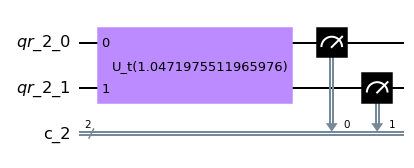

In [16]:
G=U_t(np.pi/3)
# initial circuit 
qr=QuantumRegister(2,'qr_2')
c=ClassicalRegister(2,'c_2')
qc_2=QuantumCircuit(qr,c)

qc_2.append(G,qr)
qc_2.measure(qr,c)

qc_2.draw('mpl')

## Initial state 

In [17]:
init=np.zeros((2**2,2**2))
init[0][0]=1
print("Initial density:")
for i in init:
    print(i)
    
    
new=new_state(init,op_2)
print("\n New density:")
for i in new:
    print(i)


Initial density:
[1. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]
[0. 0. 0. 0.]

 New density:
[0.25+0.j   0.  -0.25j 0.  +0.j   0.  +0.j  ]
[0.  +0.25j 0.25+0.j   0.  +0.j   0.  +0.j  ]
[0.  +0.j   0.  +0.j   0.25+0.j   0.  -0.25j]
[0.  +0.j   0.  +0.j   0.  +0.25j 0.25+0.j  ]


In [18]:
print("C2:")
C2=corelation(init,op_2)
for i in C2:
    print(i)
    
coef_C2,label_C2=decompose(C2)

print("C2 decompose:")
for i in range(len(coef_C2)):
    if(coef_C2[i]!=0):
        print('{}:{}'.format(label_C2[i],coef_C2[i]))

C2:
[0j, (-1+0j), 0j, 0j]
[(1+0j), 0j, 0j, 0j]
[0j, 0j, 0j, (-1+0j)]
[0j, 0j, (1+0j), 0j]
C2 decompose:
IY:-1j


In [19]:
coef_C2,label_C2=decompose(C2)

for i in range(len(coef_C2)):
    if(coef_C2[i]!=0):
        print('{}:{}'.format(label_C2[i],coef_C2[i]))

IY:-1j


In [20]:
new_C2=(1j*(-1.j*np.kron(I,Y))+np.kron(I,I))*(1/4)
print(new_C2)

[[0.25+0.j   0.  -0.25j 0.  +0.j   0.  +0.j  ]
 [0.  +0.25j 0.25+0.j   0.  +0.j   0.  +0.j  ]
 [0.  +0.j   0.  +0.j   0.25+0.j   0.  -0.25j]
 [0.  +0.j   0.  +0.j   0.  +0.25j 0.25+0.j  ]]


In [21]:
c,l=decompose(new_C2)
for i in range(len(l)):
    if(c[i]!=0):
        print('{}:{}'.format(l[i],c[i]))

II:(0.25+0j)
IY:(0.25+0j)


## Gates

In [22]:
print("ZI")
print(np.kron(Z,I))
print("IZ")
print(np.kron(I,Z))
print("XX")
print(np.kron(X,X))
print("YY")
print(np.kron(Y,Y))


ZI
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j -0.+0.j -1.+0.j]]
IZ
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  0.+0.j -0.+0.j]
 [ 0.+0.j  0.+0.j  1.+0.j  0.+0.j]
 [ 0.+0.j -0.+0.j  0.+0.j -1.+0.j]]
XX
[[0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j]]
YY
[[ 0.+0.j  0.-0.j  0.-0.j -1.+0.j]
 [ 0.+0.j  0.+0.j  1.-0.j  0.-0.j]
 [ 0.+0.j  1.-0.j  0.+0.j  0.-0.j]
 [-1.+0.j  0.+0.j  0.+0.j  0.+0.j]]


In [23]:
#Now let's see how we can compress a gate.(G)
t=0
G=U_t(3)
G_mat=swap_t(t)
print(G_mat.mat)


[[ 1.  0.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  1. -0.  0.]
 [ 0.  0.  0. -1.]]


In [24]:
a=2*np.pi/9;b=0

###########################
#just some math to explor how we cn reprezent our gates .#

#A=(np.sin(a)**2)*np.kron(I,Z)+ (np.sin(a*2)*np.kron(X,X)+ np.sin(a*2)*np.kron(Y,Y))/2+(np.cos(a)**2)*np.kron(Z,I)

#2sin(A)sin(B)=cos(A-B)+cos(A+B)
#2sin(A)sin(A)=cos(A-A)+cos(A+A)=1+cos(2A)

#2cos(A)cos(B)=cos(A+B)-cos(A-B)
#2cos(A)cos(A)=cos(2A)-1

##############################


B=(1-np.cos(a*2))/2*np.kron(I,Z)+ (np.sin(a*2)*np.kron(X,X)+ np.sin(a*2)*np.kron(Y,Y))/2+(np.cos(a*2)+1)/2*np.kron(Z,I)
print("A(a)=B(a):")
print(B)
print("######################################################")

print("B decompose:")
c,l=decompose(O)
for i in range(len(l)):
    if(abs(c[i])>=0.00000000001):
        print('{}:{}'.format(l[i],c[i])) 
print("######################################################")
print('\n')

print("######################################################")

O=logm(B)  #ln(B)
print("ln(B)")
print(O)
print("######################################################")

print("O decompose")
c,l=decompose(O)
for i in range(len(l)):
    if(abs(c[i])>=0.00000000001):
        print('{}:{}'.format(l[i],c[i]))
print("######################################################")
print('\n')

print("######################################################")

b=np.arcsin(0.7734662005153561)
S= np.pi/2*(1j*(np.kron(I,I))-1j*np.cos(b)*np.kron(I,Z)-1j*(1-np.cos(b))*np.kron(Z,I)-1j*np.sin(b)*(np.kron(Y,Y)+np.kron(X,X)))
print("S:")
print(S) 
print("######################################################")

print("S decompose")
c,l=decompose(S)
for i in range(len(l)):
    if(abs(c[i])>=0.00000000001):
        print('{}:{}'.format(l[i],c[i]))
print("######################################################")
print('\n')

print("######################################################")

print("Se:")
S_e=expm(S)
print(S_e) 
print("######################################################")

print("######################################################")
print('\n')

Dif=S_e-B
print(Dif)
s=0
for i in range(len(Dif)):
    for j in Dif[i]:
        s=s+abs(j)
print("abs_Sum",s)
print("######################################################")
print('\n')


print("Bl")
Bl=expm(1j*np.pi/2*B)
B2=-1j*Bl
print(B2)
print("######################################################")
print('\n')

print('Dif2')
Dif_2=B2-B
print(Dif_2)
s=0
for i in range(len(Dif_2)):
    for j in Dif_2[i]:
        s=s+abs(j)
print("abs_Sum",s)

A(a)=B(a):
[[ 1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.17364818+0.j  0.98480775+0.j  0.        +0.j]
 [ 0.        +0.j  0.98480775+0.j -0.17364818+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j -1.        +0.j]]
######################################################
B decompose:
ZX:(1+0j)
######################################################


######################################################
ln(B)
[[ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j         -1.49083158e-16+1.29803041j
   1.77670389e-16-1.5469324j   0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          1.77670389e-16-1.5469324j
  -2.11739325e-16+1.84356225j  0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j         -3.60822483e-16+3.14159265j]]
######################################################
O decompose
II:(-

In [25]:
## Jist to see some possible gates 
## Definitely Bl method is better
## for k in range(1,500): 
#    b=2*np.pi/k
#    B=(1-np.cos(a*2))/2*np.kron(I,Z)+ (np.sin(a*2)*np.kron(X,X)+ np.sin(a*2)*np.kron(Y,Y))/2+(np.cos(a*2)+1)/2*np.kron(Z,I)
#    O=-1j*expm(1j*np.pi/2*B)
#    print('Oooooooooo')
#    print(O)

In [26]:
#Let's try to found a path to decompose our B in op_n elementss
print("######################################################")
print("C:")
C=op_2.elements
for i in range(len(C)):
    print("C[{}]".format(i))
    print_decompose(C[i])
print("######################################################")
print('\n')

print("######################################################")
print("C_iC_j:")
for i in range(len(C)):
    for j in range(len(C)):
        if (i!=j)and (i>j):
            print("\n C[{}]C[{}]".format(i,j)) 
            print_decompose(np.matmul(C[i],C[j]))
print("######################################################")

######################################################
C:
C[0]
XI:(1+0j)
C[1]
YI:(1+0j)
C[2]
ZX:(1+0j)
C[3]
ZY:(1+0j)
######################################################


######################################################
C_iC_j:

 C[1]C[0]
ZI:-1j

 C[2]C[0]
YX:1j

 C[2]C[1]
XX:-1j

 C[3]C[0]
YY:1j

 C[3]C[1]
XY:-1j

 C[3]C[2]
IZ:-1j
######################################################


In [27]:
a=2*np.pi/9
B= 1j*((1-np.cos(a*2))/2*np.matmul(C[3],C[2])+(np.sin(a*2)*np.matmul(C[2],C[1])-np.sin(a*2)*np.matmul(C[3],C[0]))/2+(np.cos(a*2)+1)/2*np.matmul(C[1],C[0]))
Bl=expm(-1j*np.pi/2*B)
B2=1j*Bl

In [28]:
# /   0                    1.                   2.                   3
# 0   0                    -(np.cos(a*2)+1)/4   0                    np.sin(a*2)/2 
# 1   (np.cos(a*2)+1)/4    0                    -np.sin(a*2)/4       0
# 2   0                    np.sin(a*2)/4        0                    -(1-np.cos(a*2))/4 
# 3   -np.sin(a*2)/4       0                    (1-np.cos(a*2))/4    0

B=1j*((np.cos(a*2)+1)/4*(np.matmul(C[1],C[0])-np.matmul(C[0],C[1]))
      +np.sin(a*2)/4*(np.matmul(C[2],C[1])-np.matmul(C[1],C[2]))
      +(1-np.cos(a*2))/4*(np.matmul(C[3],C[2])-np.matmul(C[2],C[3]))
      -np.sin(a*2)/4*(np.matmul(C[3],C[0])-np.matmul(C[0],C[3])))
    
print("B")
print(B)
Bl=expm(-1j*np.pi/2*B)
B2=1j*Bl  # ! don't forget 1j
print(B2)

B
[[ 1.        +0.j  0.        +0.j  0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.17364818+0.j  0.98480775+0.j  0.        +0.j]
 [ 0.        +0.j  0.98480775+0.j -0.17364818+0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j -1.        +0.j]]
[[ 1.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.17364818-3.12250226e-17j
   0.98480775-2.77555756e-17j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.98480775-2.77555756e-17j
  -0.17364818-5.55111512e-17j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j -1.        +0.00000000e+00j]]


In [29]:
# Let's generalize for more qubits

#qubit
#k: 0        | 1        | 2         | 3         |  4        |   5         |...
#   c_0  c_1 | c_2  c_3 | c_4  c_5  | c_6   c_7 | c_8   c_9 | c_10   c_11 |...

#c_k   =Z...Zx_kI...I
#c_{2k+1}=Z...Zy_{2k}I...I

#B_{k_1,k_2,a}=1j*((np.cos(a*2)+1)/4*(np.matmul(C[k_1+1],C[k_1])-np.matmul(C[k_1],C[k_1+1]))
#                  +np.sin(a*2)/4*(np.matmul(C[k_2],C[k_1+1])-np.matmul(C[k_1+1],C[k_2]))
#                  +(1-np.cos(a*2))/4*(np.matmul(C[k_2+3],C[k_2])-np.matmul(C[k_2],C[k_2+1]))
#                  -np.sin(a*2)/4*(np.matmul(C[k_2+1],C[k_1])-np.matmul(C[k_1],C[k_2+1])))



In [30]:
k_1=1
k_2=2
C=x_op(4).elements
B=1j*((np.cos(a*2)+1)/4*(np.matmul(C[2*k_1+1],C[2*k_1])-np.matmul(C[2*k_1],C[2*k_1+1]))
         +np.sin(a*2)/4*(np.matmul(C[2*k_2],C[2*k_1+1])-np.matmul(C[2*k_1+1],C[2*k_2]))
     +(1-np.cos(a*2))/4*(np.matmul(C[2*k_2+1],C[2*k_2])-np.matmul(C[2*k_2],C[2*k_2+1]))
         -np.sin(a*2)/4*(np.matmul(C[2*k_2+1],C[2*k_1])-np.matmul(C[2*k_1],C[2*k_2+1])))

In [31]:
#remake:

class B:
    def __init__(self,theata):
        self.theta=theata
        self.mat=np.array([[1,0,0,0],
                           [0,np.sin(self.theta),np.cos(self.theta),0],
                           [0,np.cos(self.theta),-1*np.sin(self.theta),0],
                           [0,0,0,-1]])
        self()
     
def U_t(theta):
    qc=QuantumCircuit(2,name='U_t('+str(theta)+')')
    qc.unitary(swap_t(theta).mat,[0,1])
    return qc.to_gate()

In [32]:
k_1=1
k_2=2
C=x_op(4).elements
B=1j*((np.cos(a*2)+1)/4*(np.matmul(C[2*k_1+1],C[2*k_1])-np.matmul(C[2*k_1],C[2*k_1+1]))
         +np.sin(a*2)/4*(np.matmul(C[2*k_2],C[2*k_1+1])-np.matmul(C[2*k_1+1],C[2*k_2]))
     +(1-np.cos(a*2))/4*(np.matmul(C[2*k_2+1],C[2*k_2])-np.matmul(C[2*k_2],C[2*k_2+1]))
         -np.sin(a*2)/4*(np.matmul(C[2*k_2+1],C[2*k_1])-np.matmul(C[2*k_1],C[2*k_2+1])))

In [33]:
class R_gate:
    def __init__(self,gate,k_1,k_2,size):
        #gate=deasire swap_t ;k_1=first qbit; k_2=second qbit; size= total nr of qbits
        self.k_1=k_1
        self.k_2=k_2
        self.gate=gate
        self.a=gate.theta
        self.size=size
        self.mat=0
        
    def get_R_mat(self):
        a=self.a/2
        R=np.zeros((2*self.size,2*self.size))
        k_1=self.k_1
        k_2=self.k_2
        R[2*k_1+1][2*k_1]=(np.cos(a*2)+1)/4
        R[2*k_1][2*k_1+1]=-(np.cos(a*2)+1)/4
        R[2*k_2][2*k_1+1]=np.sin(a*2)/4
        R[2*k_1+1][2*k_2]=-np.sin(a*2)/4
        R[2*k_2+1][2*k_2]=(1-np.cos(a*2))/4
        R[2*k_2][2*k_2+1]=-(1-np.cos(a*2))/4
        R[2*k_2+1][2*k_1]=-np.sin(a*2)/4
        R[2*k_1][2*k_2+1]=np.sin(a*2)/4
        self.mat=R

In [37]:
print("##################################################################")
a=2*np.pi/9
b=swap_t(2*np.pi/9)
print("b:")
print(b.mat)
print("##################################################################")
print_decompose(b.mat)
print("##################################################################\n")

print("##################################################################")
k_1=1
k_2=2
print("R_b_{}_{}:".format(k_1,k_2))
r=R_gate(b,k_1,k_2,4)
r.get_R_mat()
print(r.mat)
print("##################################################################")
print_decompose(r.mat)
print("##################################################################")

##################################################################
b:
[[ 1.          0.          0.          0.        ]
 [ 0.          0.64278761  0.76604444  0.        ]
 [ 0.          0.76604444 -0.64278761  0.        ]
 [ 0.          0.          0.         -1.        ]]
##################################################################
IZ:(0.17860619515673037+0j)
XX:(0.38302222155948906+0j)
YY:(0.38302222155948906+0j)
ZI:(0.8213938048432696+0j)
##################################################################

##################################################################
R_b_1_2:
[[ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.         -0.44151111  0.          0.1606969
   0.          0.        ]
 [ 0.          0.          0.44151111  0.         -0.1606969   0.
   0.          0.        ]
 [ 0.          0.       

In [162]:
# generate R  from B

In [163]:
print_decompose(B)

IIZI:(0.41317591116653474+0j)
IXXI:(0.492403876506104+0j)
IYYI:(0.492403876506104+0j)
IZII:(0.5868240888334653+0j)


In [167]:
np.matmul(r.mat,r.mat)

array([[-0.22075556,  0.        ,  0.08034845,  0.        ],
       [ 0.        , -0.22075556,  0.        ,  0.08034845],
       [ 0.08034845,  0.        , -0.02924444,  0.        ],
       [ 0.        ,  0.08034845,  0.        , -0.02924444]])

In [165]:
a=2*np.pi/9
b=swap_t(2*np.pi/9)

r=R_gate(b,0,1,2)#k_1=0,k_2=1
r.get_R_mat()
print(r.mat)

[[ 0.         -0.44151111  0.          0.1606969 ]
 [ 0.44151111  0.         -0.1606969   0.        ]
 [ 0.          0.1606969   0.         -0.05848889]
 [-0.1606969   0.          0.05848889  0.        ]]


In [38]:
# pseudo compres
qr=QuantumRegister(2,'qr_2')
c=ClassicalRegister(2,'c_2')
qc_2=QuantumCircuit(qr,c)


#new initial state
qc_2.y(qr[1])
#new gate
qc_2.unitary(4*r.mat,qr)

qc_2.draw('mpl')

ExtensionError: 'Input matrix is not unitary.'

In [ ]:
statevector_bg=Aer.get_backend('statevector_simulator')

In [ ]:
exp=execute(qc_2,backend=statevector_bg)
result=exp.result()
statevector=result.get_statevector(qc_2,decimals=1)
print(statevector)

In [ ]:
backend = Aer.get_backend('unitary_simulator')
job = execute(qc_2, backend)
result = job.result()
unitary=result.get_unitary(qc_2, decimals=1)

for i in unitary:
    print(i)

In [ ]:
new
print(new.trace())

In [ ]:
qb=QuantumRegister(4,'qb')
qc=QuantumCircuit(qb)
#qc.unitary(new,qb)
qc.initialize
qc.draw('mpl')

In [ ]:
#Real deal

In [ ]:
basis='sto3g'
inter_dist=1.4
# Molecule
atoms = 'Li .0 .0 .0; H .0 .0 '+str(inter_dist)
driver = PySCFDriver(atoms, unit=UnitsType.ANGSTROM, charge=0, spin=0, basis=basis,max_memory=None)

#integral h_{lm} , h_{lmpq}
molecule = driver.run()
h1 = molecule.one_body_integrals
h2 = molecule.two_body_integrals
nuclear_repulsion_energy = molecule.nuclear_repulsion_energy

num_particles = molecule.num_alpha + molecule.num_beta
num_spin_orbitals = molecule.num_orbitals * 2

#freez some
freeze_list = [0]
remove_list = [-3, -2]

remove_list = [x % molecule.num_orbitals for x in remove_list]
freeze_list = [x % molecule.num_orbitals for x in freeze_list]
remove_list = [x - len(freeze_list) for x in remove_list]
remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    


print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))

ferOp = FermionicOperator(h1=h1, h2=h2)

ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
num_spin_orbitals -= len(freeze_list)
num_particles -= len(freeze_list)

ferOp = ferOp.fermion_mode_elimination(remove_list)
num_spin_orbitals -= len(remove_list)

qubitOp = ferOp.mapping(map_type='jordan_wigner')

print("!! After freezing and remouve:")
print("HF energy: {}".format(molecule.hf_energy - molecule.nuclear_repulsion_energy))
print('Freez energy shift: {}'.format(energy_shift))
print("# nr. of electrons: {}".format(num_particles))
print("# nr. of spin orbitals: {}".format(num_spin_orbitals))        

In [ ]:
weight=[]
pauli=[]
for w,i in qubitOp._paulis:
    weight.append(w)
    pauli.append(i.to_label())
    
for i in range(len(weight)):
    print("{}-{}".format(pauli[i],weight[i]))

In [ ]:
#initial circuit :
nr_o=num_spin_orbitals
nr_e=num_particles
nr_par=(nr_o-nr_e)*nr_e
theta=np.zeros(nr_par)
qo=QuantumRegister(nr_o,'qo')
ansatz = QuantumCircuit(qo)
ansatz_cell(ansatz,qo,nr_o, nr_e,theta)
ansatz.draw('mpl')
circ=var_circ(nr_o,nr_e,theta)
print('theta =',theta)
print(value(weight,pauli,circ,backend))
circ.draw('mpl')

In [ ]:
#comprssion
# inital state : r=1\(2n)[I+iC(r_{in})]
# C=</psi_{in}|ic_jc_k|/psi_{in}>

I_2n=np.identity(2*nr_o)
C=np.zeros((2*nr_o,2*nr_o))
print('C:')
for i in C:
    print(i)
    

In [ ]:
for i in I_2n:
    print(i)